In [62]:
import pandas as pd
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import numpy as np
from sklearn.linear_model import LinearRegression
from arch.unitroot import ADF

,Date,Open,High,Low,Close,tick_volume,spread,real_volume,return,returnShift,M20,noTrend,lag1,lag2,alvo,z
21,2020-02-11,1.29150,1.29680,1.28945,1.29533,57868,0,0,0.00395,0.00032,1.303136,-0.007806,-0.012085,-0.015276,-0.007078,-0.282203
22,2020-02-12,1.29503,1.29915,1.29484,1.29565,56525,0,0,0.00032,0.00840,1.302728,-0.007078,-0.007806,-0.012085,0.001505,-0.253827
23,2020-02-13,1.29588,1.30693,1.29441,1.30405,69693,0,0,0.00840,0.00058,1.302545,0.001505,-0.007078,-0.007806,0.001883,0.080968
24,2020-02-14,1.30404,1.30635,1.30011,1.30463,53088,0,0,0.00058,-0.00433,1.302747,0.001883,0.001505,-0.007078,-0.002415,0.095732
25,2020-02-17,1.30304,1.30538,1.29984,1.30030,42774,0,0,-0.00433,-0.00064,1.302715,-0.002415,0.001883,0.001505,-0.002802,-0.071949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,2020-10-09,1.29330,1.30496,1.29160,1.30459,75113,0,0,0.01119,0.00192,1.287705,0.016885,0.006946,0.005997,0.017707,0.680839
195,2020-10-12,1.30228,1.30826,1.30052,1.30651,62898,0,0,0.00192,-0.01305,1.288803,0.017707,0.016885,0.006946,0.004428,0.712900
196,2020-10-13,1.30633,1.30680,1.29218,1.29346,89557,0,0,-0.01305,0.00768,1.289032,0.004428,0.017707,0.016885,0.011888,0.194959
197,2020-10-14,1.29331,1.30644,1.28627,1.30114,88507,0,0,0.00768,-0.01081,1.289252,0.011888,0.004428,0.017707,0.001427,0.485933


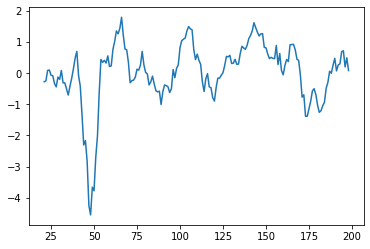

In [63]:
if not mt5.initialize(path="C:\Program Files\MetaTrader 5\\terminal64.exe"):
    print("initialize() failed, error code =", mt5.last_error())
    quit()
rates = mt5.copy_rates_from_pos("GBPUSD", mt5.TIMEFRAME_D1, 0 , 200)
a = pd.DataFrame(rates)
a['time'] = pd.to_datetime(a['time'], unit='s')
a.rename(columns={"time": "Date","open": "Open", "high": "High","low": "Low", "close": "Close" },inplace=True)
a['return'] = a['Close'] - a['Close'].shift(1)
a['returnShift'] = a['return'].shift(-1)
a['M20'] = a['Close'].rolling(20).mean()
a['noTrend'] = a['Close'] - a['M20']
a['lag1'] = a['noTrend'].shift(1)
a['lag2'] = a['noTrend'].shift(2)
a['alvo'] = a['noTrend'].shift(-1)
media = a['noTrend'].mean()
dp = a['noTrend'].std()
a['z'] = (a['noTrend'] - media)/dp
a.dropna(inplace=True)
#print(a['z'].describe())
#print(sms.DescrStatsW(a['alvo']).tconfint_mean())
a['z'].plot()
a

count    178.000000
mean      -0.000006
std        0.009286
min       -0.042410
25%       -0.005015
50%        0.000745
75%        0.005640
max        0.031870
Name: return, dtype: float64


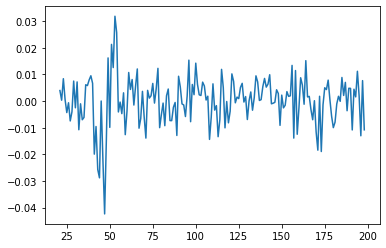

In [64]:
print(a['return'].describe())
a['return'].plot()


count    1.780000e+02
mean    -1.247442e-18
std      1.000000e+00
min     -4.621993e+00
25%     -5.582695e-01
50%      1.069534e-01
75%      6.298996e-01
max      2.395224e+00
Name: z, dtype: float64


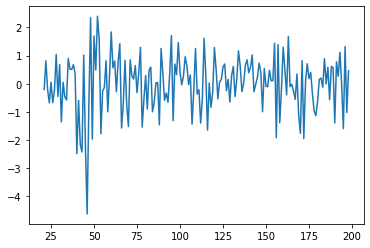

In [79]:
variaveis= ['noTrend','lag1', 'lag2']
x = a[variaveis]
y = a['alvo']
reg = LinearRegression().fit(x, y)
resultado = reg.predict(x)
a['previsao'] = resultado
a['residuos'] = a['alvo'] - resultado
media = a['residuos'].mean()
dp = a['residuos'].std()
a['z'] = (a['residuos'] - media)/dp
a.dropna(inplace=True)
print(a['z'].describe())
#print(sms.DescrStatsW(a['alvo']).tconfint_mean())
a['z'].plot()

In [80]:
a['Bull'] = np.select([a['z'] < -2], [(a['returnShift'])], default=0)

a['Bear'] = np.select([a['z'] > 2 ], [(- a['returnShift'])], default=0)

a['ResultCum'] = np.cumsum(a['Bull'] + a['Bear'])
a

,Date,Open,High,Low,Close,tick_volume,spread,real_volume,return,returnShift,...,noTrend,lag1,lag2,alvo,z,previsao,Bull,Bear,ResultCum,residuos
21,2020-02-11,1.29150,1.29680,1.28945,1.29533,57868,0,0,0.00395,0.00032,...,-0.007806,-0.012085,-0.015276,-0.007078,-0.203339,-0.005347,0.0,0.0,0.00000,-0.001731
22,2020-02-12,1.29503,1.29915,1.29484,1.29565,56525,0,0,0.00032,0.00840,...,-0.007078,-0.007806,-0.012085,0.001505,0.812542,-0.005413,0.0,0.0,0.00000,0.006918
23,2020-02-13,1.29588,1.30693,1.29441,1.30405,69693,0,0,0.00840,0.00058,...,0.001505,-0.007078,-0.007806,0.001883,-0.213426,0.003701,0.0,0.0,0.00000,-0.001817
24,2020-02-14,1.30404,1.30635,1.30011,1.30463,53088,0,0,0.00058,-0.00433,...,0.001883,0.001505,-0.007078,-0.002415,-0.680457,0.003378,0.0,0.0,0.00000,-0.005793
25,2020-02-17,1.30304,1.30538,1.29984,1.30030,42774,0,0,-0.00433,-0.00064,...,-0.002415,0.001883,0.001505,-0.002802,0.052905,-0.003252,0.0,0.0,0.00000,0.000450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,2020-10-09,1.29330,1.30496,1.29160,1.30459,75113,0,0,0.01119,0.00192,...,0.016885,0.006946,0.005997,0.017707,-0.028763,0.017951,0.0,0.0,-0.18711,-0.000245
195,2020-10-12,1.30228,1.30826,1.30052,1.30651,62898,0,0,0.00192,-0.01305,...,0.017707,0.016885,0.006946,0.004428,-1.594562,0.018003,0.0,0.0,-0.18711,-0.013576
196,2020-10-13,1.30633,1.30680,1.29218,1.29346,89557,0,0,-0.01305,0.00768,...,0.004428,0.017707,0.016885,0.011888,1.319070,0.000657,0.0,0.0,-0.18711,0.011230
197,2020-10-14,1.29331,1.30644,1.28627,1.30114,88507,0,0,0.00768,-0.01081,...,0.011888,0.004428,0.017707,0.001427,-1.022865,0.010136,0.0,0.0,-0.18711,-0.008709


count    178.000000
mean      -0.161435
std        0.061340
min       -0.187110
25%       -0.187110
50%       -0.187110
75%       -0.187110
max        0.000000
Name: ResultCum, dtype: float64


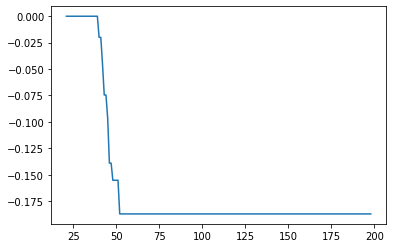

In [81]:
print(a['ResultCum'].describe())
a['ResultCum'].plot()

In [78]:
adf = ADF(a['residuos'])
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -6.532
P-value                         0.000
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
